In [1]:
import anndata as ad
import scanpy as sc
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt


import scgen

/home/louise/Work/dynchro_paper/.venv/lib/python3.12/site-packages/docrep/decorators.py:43: SyntaxWarning: 'param_categorical_covariate_keys' is not a valid key!
  doc = func(self, args[0].__doc__, *args[1:], **kwargs)
/home/louise/Work/dynchro_paper/.venv/lib/python3.12/site-packages/docrep/decorators.py:43: SyntaxWarning: 'param_continuous_covariate_keys' is not a valid key!
  doc = func(self, args[0].__doc__, *args[1:], **kwargs)


In [2]:
import torch
import random

# note that this does not make the result reproducible

torch.manual_seed(0)
np.random.seed(0)
random.seed(0)

In [3]:
from utils import plot_iroot, comp_kde, kdeplot, kdeplot2

In [4]:
d1 = ad.read_h5ad("data/dataseta0_processed.h5ad")
d2 = ad.read_h5ad("data/datasetb0_processed.h5ad")
d2.obs["milestones"] = d2.obs.milestones.cat.rename_categories({'sC': 'sC_batch'})

In [5]:
datasets_mapping = {
    "control": d1,
    "premature stop": d2
}
datasets = ad.concat(datasets_mapping, label="batch")
datasets.obs_names_make_unique()

/home/louise/Work/dynchro_paper/.venv/lib/python3.12/site-packages/anndata/_core/anndata.py:1756: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")


# scGen, using sC and sC_batch

In [6]:
scgen.SCGEN.setup_anndata(datasets, batch_key="batch", labels_key="milestones")
model = scgen.SCGEN(datasets)
model.train(
    max_epochs=100,
    batch_size=16,
    early_stopping=True,
    early_stopping_patience=25,
)

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/louise/Work/dynchro_paper/.venv/lib/python3.12/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:425: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=21` in the `DataLoader` to improve performance.
/home/louise/Work/dynchro_paper/.venv/lib/python3.12/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:425: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=21` in the `DataLoader` to improve performance.


Training:   0%|          | 0/100 [00:00<?, ?it/s]

Monitored metric elbo_validation did not improve in the last 25 records. Best score: 1540.589. Signaling Trainer to stop.


In [7]:
corrected_adata = model.batch_removal()

INFO     Input AnnData not setup with scvi-tools. attempting to transfer AnnData setup                             


/home/louise/Work/dynchro_paper/.venv/lib/python3.12/site-packages/anndata/_core/anndata.py:602: FutureWarning: You are attempting to set `X` to a matrix on a view which has non-unique indices. The resulting `adata.X` will likely not equal the value to which you set it. To avoid this potential issue, please make a copy of the data first. In the future, this operation will throw an error.
  warnings.warn(msg, FutureWarning, stacklevel=1)
/home/louise/Work/scgen/scgen/_scgen.py:265: ImplicitModificationWarning: Modifying `X` on a view results in data being overridden
  batch_list[study].X = delta + batch_list[study].X
/home/louise/Work/scgen/scgen/_scgen.py:266: ImplicitModificationWarning: Modifying `X` on a view results in data being overridden
  temp_cell[batch_ind[study]].X = batch_list[study].X
/home/louise/Work/dynchro_paper/.venv/lib/python3.12/site-packages/anndata/_core/anndata.py:602: FutureWarning: You are attempting to set `X` to a matrix on a view which has non-unique indice

In [8]:
corrected_adata.obsm["corrected_latent"]

array([[ 4.0035152 ,  3.0425434 ,  1.8274504 , ...,  2.5602334 ,
         1.0999763 , -3.041471  ],
       [-0.06770888,  0.5740278 , -3.5228977 , ..., -0.909825  ,
        -3.4657779 , -1.3986256 ],
       [ 0.6456626 , -1.1855321 , -0.39864728, ...,  0.71067697,
        -2.1570399 , -2.3635182 ],
       ...,
       [-2.813897  , -1.8538011 , -0.42491814, ..., -0.05361076,
         0.31089175,  0.8241691 ],
       [ 1.2415453 , -2.886295  , -1.5983539 , ..., -0.47158906,
        -2.6873438 , -2.714428  ],
       [-3.2458615 , -1.1711531 ,  1.8715017 , ...,  0.36092332,
        -2.5712419 , -2.7852705 ]], shape=(1822, 100), dtype=float32)

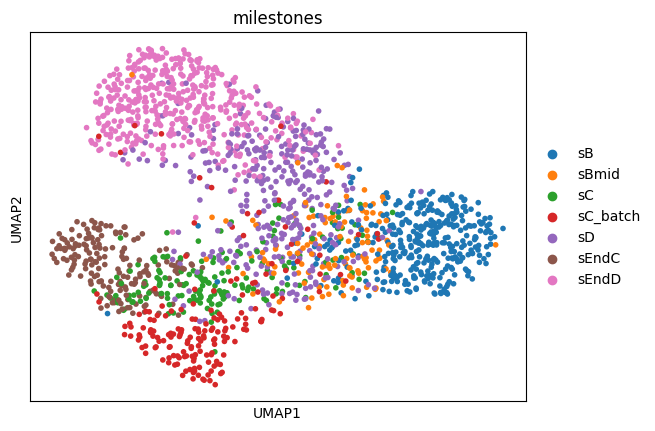

In [9]:
sc.pp.neighbors(corrected_adata, use_rep="corrected_latent")
sc.tl.umap(corrected_adata)
sc.pl.umap(corrected_adata, color = 'milestones', wspace = 0.4)

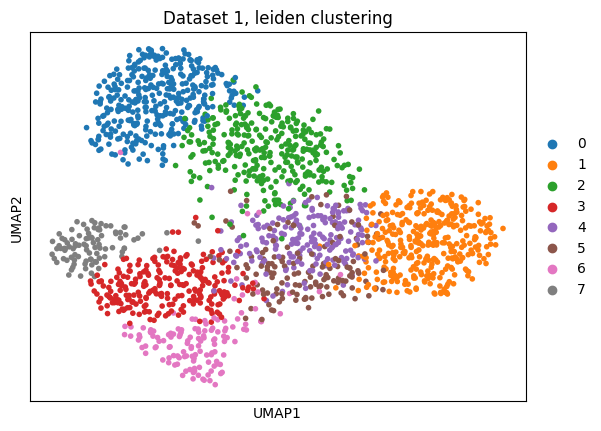

In [16]:
sc.tl.leiden(corrected_adata, resolution=1.4, key_added="leiden1")
sc.pl.umap(corrected_adata, color='leiden1', title="Dataset 1, leiden clustering")

In [17]:
corrected_adata.write_h5ad("data/scgen1.h5ad")

## Pseudotime

In [19]:
scgen1_result = ad.read_h5ad("data/scgen1_slingshot.h5ad")
scgen1_result

AnnData object with n_obs × n_vars = 1822 × 531
    obs: 'step_ix', 'simulation_i', 'sim_time', 'milestones', 'leiden', 'dpt_pseudotime', 'batch', '_scvi_batch', '_scvi_labels', 'concat_batch', 'leiden1.5', 'leiden1', 'leiden1.25', 'slingPseudotime_1', 'slingPseudotime_2', 'slingPseudotime_3'
    uns: '_scvi_manager_uuid', '_scvi_uuid', 'leiden1', 'leiden1.25', 'leiden1.25_colors', 'leiden1.5', 'leiden1.5_colors', 'leiden1_colors', 'milestones_colors', 'neighbors', 'umap'
    obsm: 'X_umap', 'corrected_latent', 'latent'
    layers: 'counts'
    obsp: 'connectivities', 'distances'

In [21]:
scgen1_result.obsm["X_corrected_latent"] = scgen1_result.obsm["corrected_latent"]

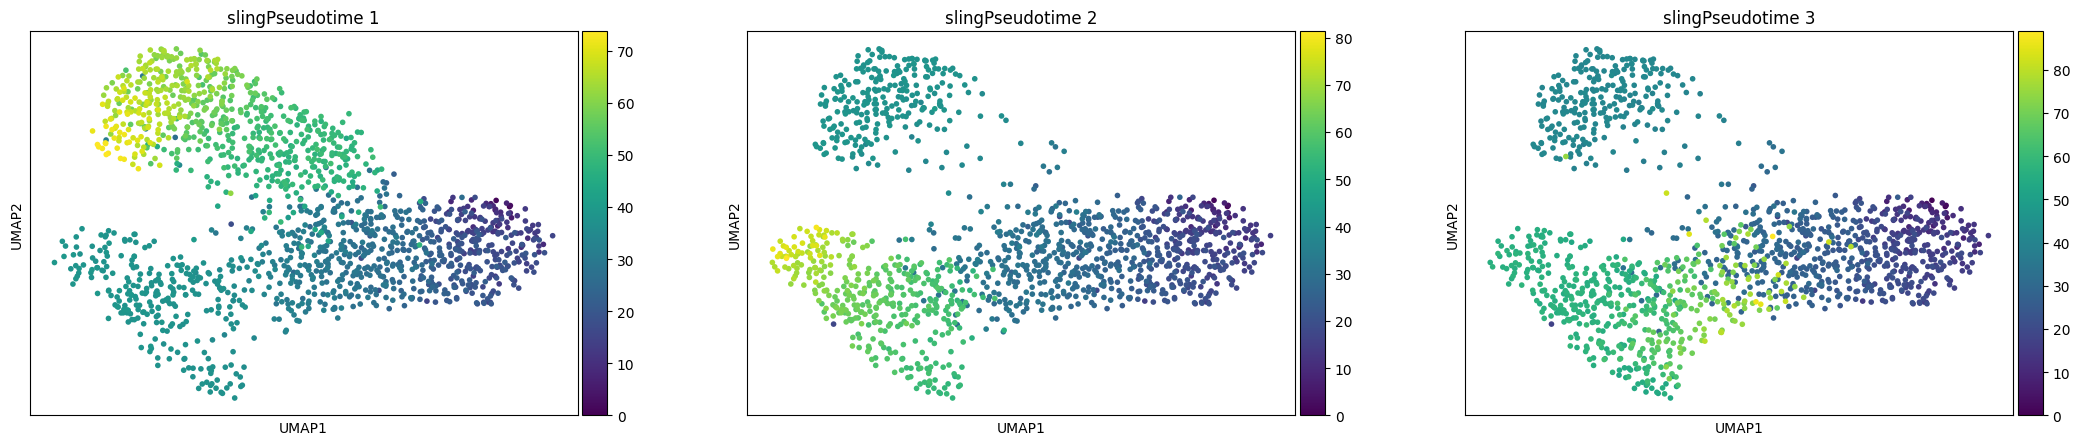

In [23]:
sc.pl.scatter(scgen1_result, basis = "umap", color = ["slingPseudotime_1", "slingPseudotime_2", "slingPseudotime_3"])

In [25]:
# select all cells in slingPseudotime_2 that are not NA there
clin = scgen1_result[~scgen1_result.obs["slingPseudotime_2"].isna()]

In [26]:
%matplotlib inline

View of AnnData object with n_obs × n_vars = 178 × 531
    obs: 'step_ix', 'simulation_i', 'sim_time', 'milestones', 'leiden', 'dpt_pseudotime', 'batch', '_scvi_batch', '_scvi_labels', 'concat_batch', 'leiden1.5', 'leiden1', 'leiden1.25', 'slingPseudotime_1', 'slingPseudotime_2', 'slingPseudotime_3'
    uns: '_scvi_manager_uuid', '_scvi_uuid', 'leiden1', 'leiden1.25', 'leiden1.25_colors', 'leiden1.5', 'leiden1.5_colors', 'leiden1_colors', 'milestones_colors', 'neighbors', 'umap'
    obsm: 'X_umap', 'corrected_latent', 'latent', 'X_corrected_latent'
    layers: 'counts'
    obsp: 'connectivities', 'distances'
View of AnnData object with n_obs × n_vars = 178 × 531
    obs: 'step_ix', 'simulation_i', 'sim_time', 'milestones', 'leiden', 'dpt_pseudotime', 'batch', '_scvi_batch', '_scvi_labels', 'concat_batch', 'leiden1.5', 'leiden1', 'leiden1.25', 'slingPseudotime_1', 'slingPseudotime_2', 'slingPseudotime_3'
    uns: '_scvi_manager_uuid', '_scvi_uuid', 'leiden1', 'leiden1.25', 'leiden1.25_c

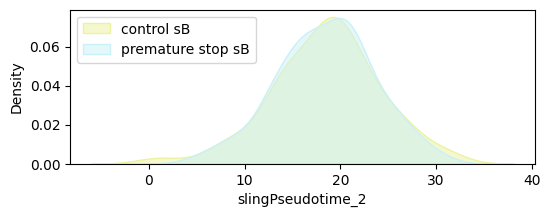

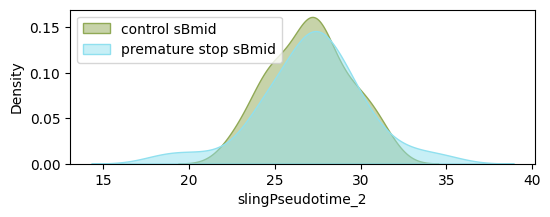

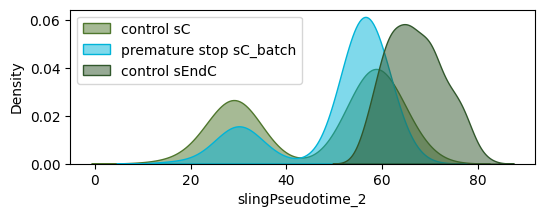

In [29]:
with plt.rc_context(rc={"figure.figsize": (6, 2)}):
    comp_kde(clin, "sB", time_column = "slingPseudotime_2", colors = ["#ecf39e", "#caf0f8"])
    comp_kde(clin, "sBmid",time_column = "slingPseudotime_2", colors = ["#90a955", "#90e0ef"])
    
    kdeplot2(clin, "control", "sC",time = "slingPseudotime_2", milestone_column = "milestones", color="#4f772d")
    kdeplot2(clin, "premature stop", "sC_batch",time = "slingPseudotime_2", milestone_column = "milestones", color="#00b4d8")
    kdeplot2(clin, "control", "sEndC", time = "slingPseudotime_2",milestone_column = "milestones", color="#31572c")
    plt.legend()

View of AnnData object with n_obs × n_vars = 178 × 531
    obs: 'step_ix', 'simulation_i', 'sim_time', 'milestones', 'leiden', 'dpt_pseudotime', 'batch', '_scvi_batch', '_scvi_labels', 'concat_batch', 'leiden1.5', 'leiden1', 'leiden1.25', 'slingPseudotime_1', 'slingPseudotime_2', 'slingPseudotime_3'
    uns: '_scvi_manager_uuid', '_scvi_uuid', 'leiden1', 'leiden1.25', 'leiden1.25_colors', 'leiden1.5', 'leiden1.5_colors', 'leiden1_colors', 'milestones_colors', 'neighbors', 'umap'
    obsm: 'X_umap', 'corrected_latent', 'latent', 'X_corrected_latent'
    layers: 'counts'
    obsp: 'connectivities', 'distances'
View of AnnData object with n_obs × n_vars = 178 × 531
    obs: 'step_ix', 'simulation_i', 'sim_time', 'milestones', 'leiden', 'dpt_pseudotime', 'batch', '_scvi_batch', '_scvi_labels', 'concat_batch', 'leiden1.5', 'leiden1', 'leiden1.25', 'slingPseudotime_1', 'slingPseudotime_2', 'slingPseudotime_3'
    uns: '_scvi_manager_uuid', '_scvi_uuid', 'leiden1', 'leiden1.25', 'leiden1.25_c

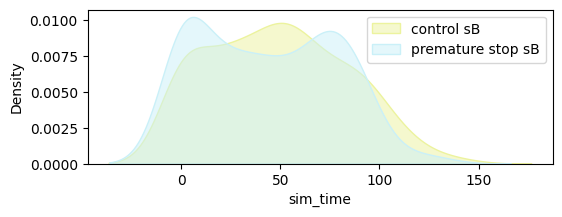

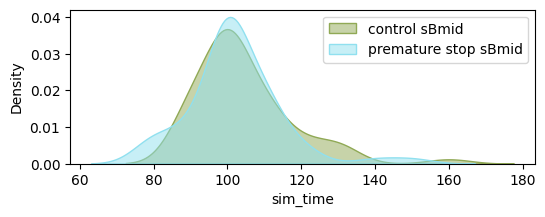

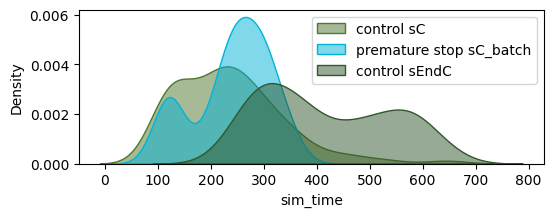

In [30]:
with plt.rc_context(rc={"figure.figsize": (6, 2)}):
    comp_kde(clin, "sB", colors = ["#ecf39e", "#caf0f8"], time_column="sim_time")
    comp_kde(clin, "sBmid", colors = ["#90a955", "#90e0ef"], time_column="sim_time")
    
    kdeplot2(clin, "control", "sC", milestone_column = "milestones", color="#4f772d", time="sim_time")
    kdeplot2(clin, "premature stop", "sC_batch", milestone_column = "milestones", color="#00b4d8", time="sim_time")
    kdeplot2(clin, "control", "sEndC", milestone_column = "milestones", color="#31572c",  time="sim_time")
    plt.legend()

# scGen, using lineage labels

In [65]:
lin_cats = {
    "sB": "sB",
    "sBmid": "sBmid",
    "sC": "sC",
    "sC_batch": "sC",
    "sEndC": "sC",
    "sD": "sD",
    "sEndD": "sD",
}

d2_lin = d2.copy()
d1_lin = d1.copy()

d2_lin.obs["milestones"] = d2_lin.obs.milestones.map(lin_cats).astype("category")
d1_lin.obs["milestones"] = d1_lin.obs.milestones.map(lin_cats).astype("category")

dm_lin = {
    "control": d1_lin,
    "premature stop": d2_lin
}
dm_lin = ad.concat(dm_lin, label="batch")
dm_lin.obs_names_make_unique()

/home/louise/Work/dynchro_paper/.venv/lib/python3.12/site-packages/anndata/_core/anndata.py:1756: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")


In [66]:
dm_lin.obs["milestones"]

cell1         sD
cell2         sD
cell3         sD
cell4         sD
cell5         sC
              ..
cell996-1     sC
cell997-1     sD
cell998-1     sD
cell999-1     sD
cell1000-1    sC
Name: milestones, Length: 1822, dtype: category
Categories (4, object): ['sB', 'sBmid', 'sC', 'sD']

In [67]:
scgen.SCGEN.setup_anndata(dm_lin, batch_key="batch", labels_key="milestones")
model_lin = scgen.SCGEN(dm_lin)
model_lin.train(
    max_epochs=100,
    batch_size=16,
    early_stopping=True,
    early_stopping_patience=25,
)
corrected_adata_lin = model_lin.batch_removal()

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/louise/Work/dynchro_paper/.venv/lib/python3.12/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:425: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=21` in the `DataLoader` to improve performance.
/home/louise/Work/dynchro_paper/.venv/lib/python3.12/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:425: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=21` in the `DataLoader` to improve performance.


Training:   0%|          | 0/100 [00:00<?, ?it/s]

Monitored metric elbo_validation did not improve in the last 25 records. Best score: 1578.457. Signaling Trainer to stop.
INFO     Input AnnData not setup with scvi-tools. attempting to transfer AnnData setup                             


/home/louise/Work/dynchro_paper/.venv/lib/python3.12/site-packages/anndata/_core/anndata.py:602: FutureWarning: You are attempting to set `X` to a matrix on a view which has non-unique indices. The resulting `adata.X` will likely not equal the value to which you set it. To avoid this potential issue, please make a copy of the data first. In the future, this operation will throw an error.
  warnings.warn(msg, FutureWarning, stacklevel=1)
/home/louise/Work/scgen/scgen/_scgen.py:265: ImplicitModificationWarning: Modifying `X` on a view results in data being overridden
  batch_list[study].X = delta + batch_list[study].X
/home/louise/Work/scgen/scgen/_scgen.py:266: ImplicitModificationWarning: Modifying `X` on a view results in data being overridden
  temp_cell[batch_ind[study]].X = batch_list[study].X
/home/louise/Work/dynchro_paper/.venv/lib/python3.12/site-packages/anndata/_core/anndata.py:602: FutureWarning: You are attempting to set `X` to a matrix on a view which has non-unique indice

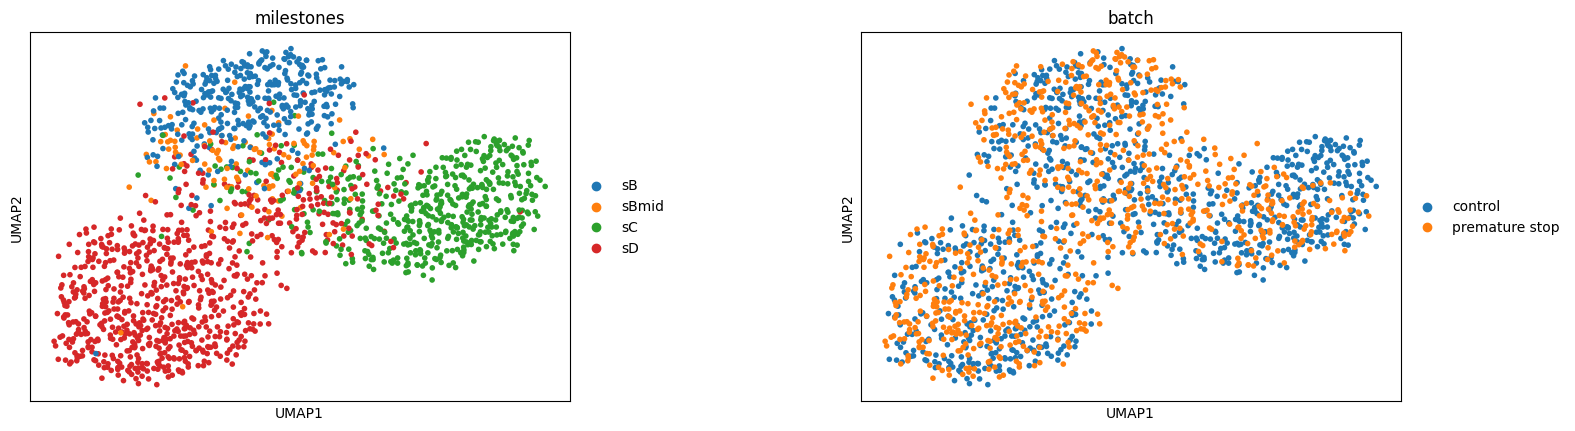

In [68]:
sc.pp.neighbors(corrected_adata_lin, use_rep="corrected_latent")
sc.tl.umap(corrected_adata_lin)
sc.pl.umap(corrected_adata_lin, color=['milestones', 'batch'], wspace=0.4)

<Axes: xlabel='x', ylabel='y'>

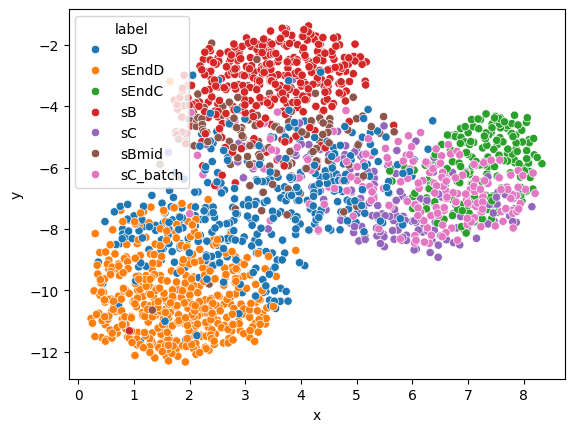

In [69]:
xvals = corrected_adata_lin.obsm["X_umap"][:, 0]
yvals = corrected_adata_lin.obsm["X_umap"][:, 1]
cats = np.concat((d1.obs["milestones"].values ,d2.obs["milestones"].values))

# create a DataFrame for the legend
legend_df = pd.DataFrame({
    "x": xvals,
    "y": yvals,
    "label": cats,
})

sns.scatterplot(
    data=legend_df,
    x="x",
    y="y",
    hue="label",
    legend=True,
)

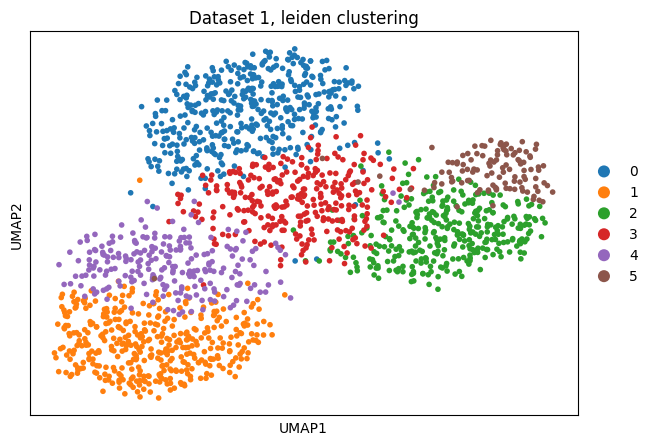

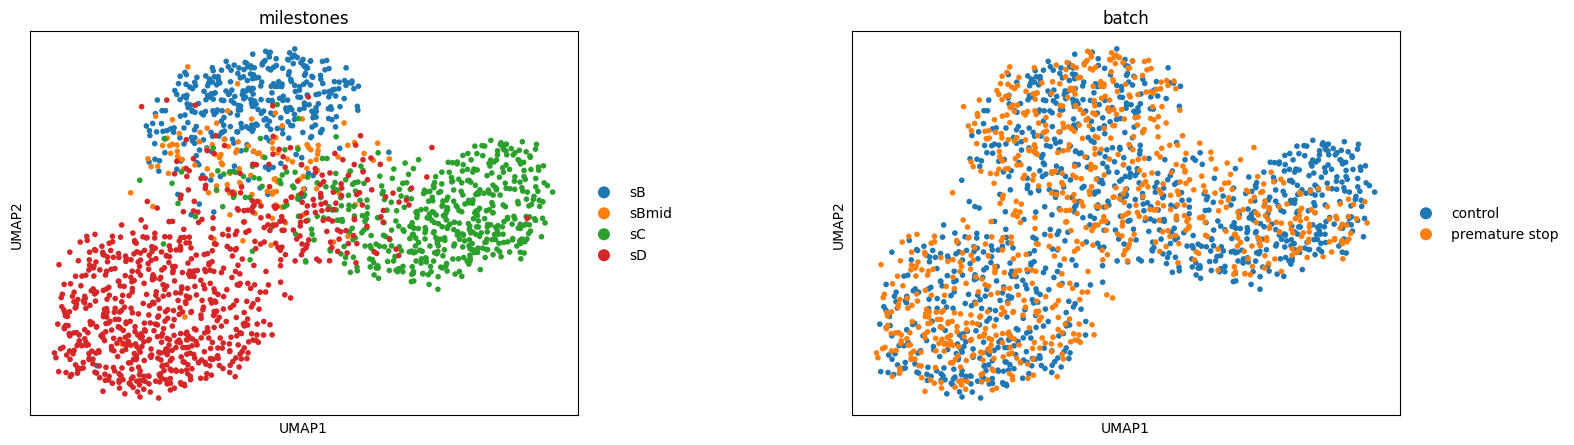

In [70]:
sc.tl.leiden(corrected_adata_lin, resolution=1, key_added="leiden1")
sc.pl.scatter(corrected_adata_lin, basis="umap", color='leiden1', title="Dataset 1, leiden clustering")
sc.pl.scatter(corrected_adata_lin, basis="umap", color=['milestones', 'batch'])

In [77]:
corrected_adata_lin.write_h5ad("data/scgen2.h5ad")

## Psuedotime

In [78]:
scgen2_result = ad.read_h5ad("data/scgen2_slingshot.h5ad")
scgen2_result

AnnData object with n_obs × n_vars = 1822 × 531
    obs: 'step_ix', 'simulation_i', 'sim_time', 'milestones', 'leiden', 'dpt_pseudotime', 'batch', '_scvi_batch', '_scvi_labels', 'leiden1', 'slingPseudotime_1', 'slingPseudotime_2'
    uns: '_scvi_manager_uuid', '_scvi_uuid', 'batch_colors', 'leiden1', 'leiden1_colors', 'milestones_colors', 'neighbors', 'umap'
    obsm: 'X_umap', 'corrected_latent', 'latent'
    layers: 'counts'
    obsp: 'connectivities', 'distances'

In [79]:
scgen2_result.obsm["X_corrected_latent"] = scgen2_result.obsm["corrected_latent"]

In [80]:
scgen2_result

AnnData object with n_obs × n_vars = 1822 × 531
    obs: 'step_ix', 'simulation_i', 'sim_time', 'milestones', 'leiden', 'dpt_pseudotime', 'batch', '_scvi_batch', '_scvi_labels', 'leiden1', 'slingPseudotime_1', 'slingPseudotime_2'
    uns: '_scvi_manager_uuid', '_scvi_uuid', 'batch_colors', 'leiden1', 'leiden1_colors', 'milestones_colors', 'neighbors', 'umap'
    obsm: 'X_umap', 'corrected_latent', 'latent', 'X_corrected_latent'
    layers: 'counts'
    obsp: 'connectivities', 'distances'

/home/louise/Work/dynchro_paper/.venv/lib/python3.12/site-packages/matplotlib/colors.py:2294: RuntimeWarning: invalid value encountered in subtract
  resdat -= vmin


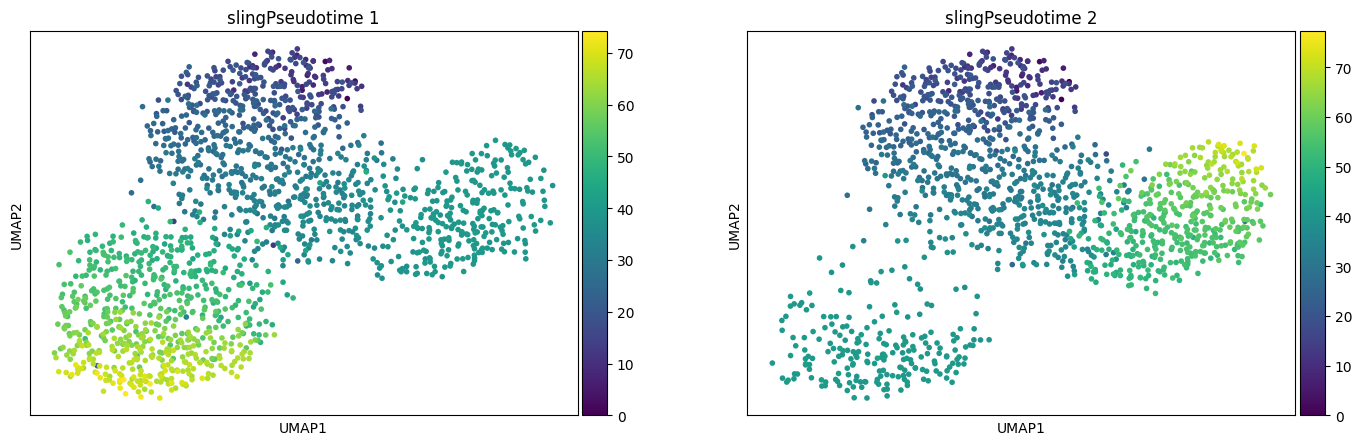

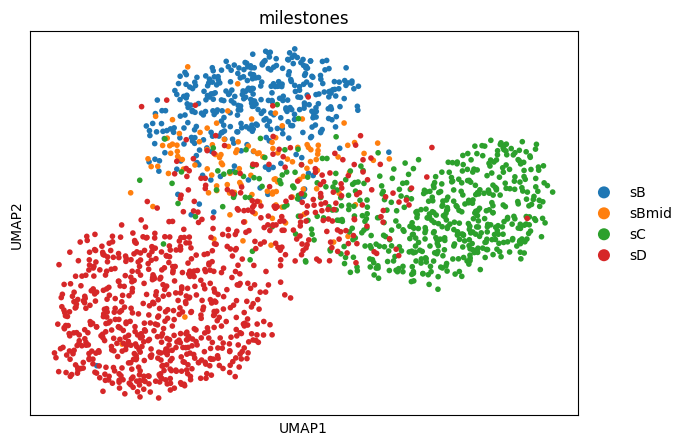

In [82]:
sc.pl.scatter(scgen2_result, basis = "umap", color = ["slingPseudotime_1", "slingPseudotime_2"])
sc.pl.scatter(scgen2_result, basis="umap", color = ["milestones"])

In [83]:
clin = scgen2_result[~scgen2_result.obs["slingPseudotime_1"].isna()]

In [ ]:
with plt.rc_context(rc={"figure.figsize": (6, 2)}):
    comp_kde(clin, "sB", time_column = "slingPseudotime_1", colors = ["#ecf39e", "#caf0f8"])
    comp_kde(clin, "sBmid",time_column = "slingPseudotime_1", colors = ["#90a955", "#90e0ef"])
    
    kdeplot2(clin, "control", "sC",time = "slingPseudotime_1", milestone_column = "milestones", color="#4f772d")
    kdeplot2(clin, "premature stop", "sC_batch",time = "slingPseudotime_1", milestone_column = "milestones", color="#00b4d8")
    kdeplot2(clin, "control", "sEndC", time = "slingPseudotime_1",milestone_column = "milestones", color="#31572c")
    plt.legend()

View of AnnData object with n_obs × n_vars = 180 × 531
    obs: 'step_ix', 'simulation_i', 'sim_time', 'milestones', 'leiden', 'dpt_pseudotime', 'batch', '_scvi_batch', '_scvi_labels', 'leiden1', 'slingPseudotime_1', 'slingPseudotime_2'
    uns: '_scvi_manager_uuid', '_scvi_uuid', 'batch_colors', 'leiden1', 'leiden1_colors', 'milestones_colors', 'neighbors', 'umap'
    obsm: 'X_umap', 'corrected_latent', 'latent', 'X_corrected_latent'
    layers: 'counts'
    obsp: 'connectivities', 'distances'
View of AnnData object with n_obs × n_vars = 179 × 531
    obs: 'step_ix', 'simulation_i', 'sim_time', 'milestones', 'leiden', 'dpt_pseudotime', 'batch', '_scvi_batch', '_scvi_labels', 'leiden1', 'slingPseudotime_1', 'slingPseudotime_2'
    uns: '_scvi_manager_uuid', '_scvi_uuid', 'batch_colors', 'leiden1', 'leiden1_colors', 'milestones_colors', 'neighbors', 'umap'
    obsm: 'X_umap', 'corrected_latent', 'latent', 'X_corrected_latent'
    layers: 'counts'
    obsp: 'connectivities', 'distances'


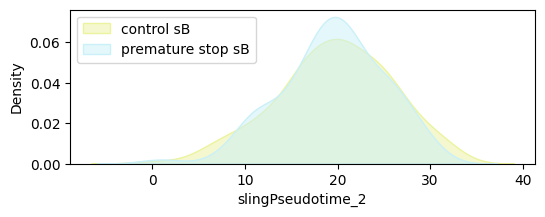

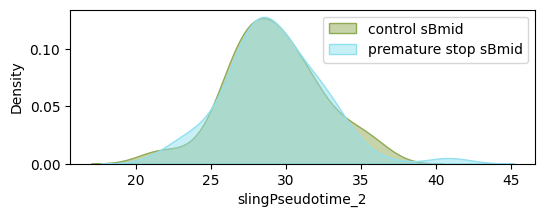

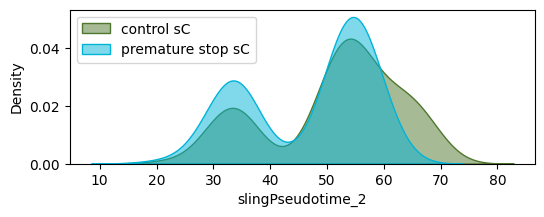

In [86]:
with plt.rc_context(rc={"figure.figsize": (6, 2)}):
    comp_kde(clin, "sB", time_column = "slingPseudotime_2", colors = ["#ecf39e", "#caf0f8"])
    comp_kde(clin, "sBmid",time_column = "slingPseudotime_2", colors = ["#90a955", "#90e0ef"])
    
    kdeplot2(clin, "control", "sC",time = "slingPseudotime_2", milestone_column = "milestones", color="#4f772d")
    kdeplot2(clin, "premature stop", "sC",time = "slingPseudotime_2", milestone_column = "milestones", color="#00b4d8")
    kdeplot2(clin, "control", "sEndC", time = "slingPseudotime_2",milestone_column = "milestones", color="#31572c")
    plt.legend()

View of AnnData object with n_obs × n_vars = 180 × 531
    obs: 'step_ix', 'simulation_i', 'sim_time', 'milestones', 'leiden', 'dpt_pseudotime', 'batch', '_scvi_batch', '_scvi_labels', 'leiden1', 'slingPseudotime_1', 'slingPseudotime_2'
    uns: '_scvi_manager_uuid', '_scvi_uuid', 'batch_colors', 'leiden1', 'leiden1_colors', 'milestones_colors', 'neighbors', 'umap'
    obsm: 'X_umap', 'corrected_latent', 'latent', 'X_corrected_latent'
    layers: 'counts'
    obsp: 'connectivities', 'distances'
View of AnnData object with n_obs × n_vars = 179 × 531
    obs: 'step_ix', 'simulation_i', 'sim_time', 'milestones', 'leiden', 'dpt_pseudotime', 'batch', '_scvi_batch', '_scvi_labels', 'leiden1', 'slingPseudotime_1', 'slingPseudotime_2'
    uns: '_scvi_manager_uuid', '_scvi_uuid', 'batch_colors', 'leiden1', 'leiden1_colors', 'milestones_colors', 'neighbors', 'umap'
    obsm: 'X_umap', 'corrected_latent', 'latent', 'X_corrected_latent'
    layers: 'counts'
    obsp: 'connectivities', 'distances'


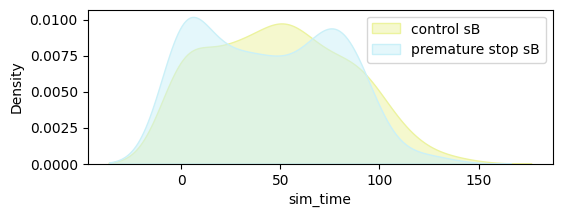

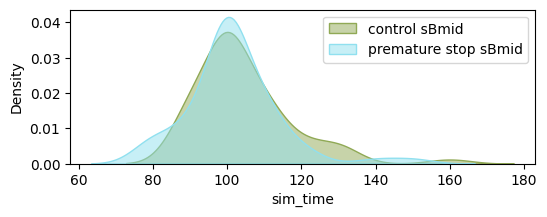

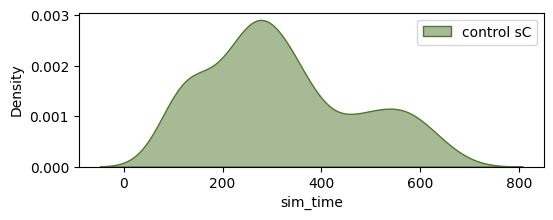

In [85]:
with plt.rc_context(rc={"figure.figsize": (6, 2)}):
    comp_kde(clin, "sB", colors = ["#ecf39e", "#caf0f8"], time_column="sim_time")
    comp_kde(clin, "sBmid", colors = ["#90a955", "#90e0ef"], time_column="sim_time")
    
    kdeplot2(clin, "control", "sC", milestone_column = "milestones", color="#4f772d", time="sim_time")
    kdeplot2(clin, "premature stop", "sC_batch", milestone_column = "milestones", color="#00b4d8", time="sim_time")
    kdeplot2(clin, "control", "sEndC", milestone_column = "milestones", color="#31572c",  time="sim_time")
    plt.legend()

In [48]:
scgen2_result

AnnData object with n_obs × n_vars = 1822 × 531
    obs: 'step_ix', 'simulation_i', 'sim_time', 'milestones', 'leiden', 'dpt_pseudotime', 'batch', '_scvi_batch', '_scvi_labels', 'concat_batch', 'leiden1.5', 'leiden1', 'leiden1.25', 'slingPseudotime_1', 'slingPseudotime_2', 'slingPseudotime_3', 'slingPseudotime_4'
    uns: '_scvi_manager_uuid', '_scvi_uuid', 'leiden1', 'leiden1.25', 'leiden1.25_colors', 'leiden1.5', 'leiden1.5_colors', 'leiden1_colors', 'milestones_colors', 'neighbors', 'umap'
    obsm: 'X_umap', 'corrected_latent', 'latent', 'X_corrected_latent'
    layers: 'counts'
    obsp: 'connectivities', 'distances'